In [ ]:
import os 
import torch 
import numpy as np 
import random
import pandas as pd

from matplotlib import pyplot as plt 

plt.rcParams["font.family"] = "Helvetica"

In [2]:
project_dir = "../../"

os.chdir(project_dir)

In [3]:
from data_generation.simulation_data import InterventionDataset

from models.helper.functions import gumbelSoftMLP, gnet_z
from models.nodags.resblock import iResBlock
from models.dccd.implicitblock import imBlock
from models.helper.layers.mlpLipschitz import linearLipschitz
from models.dccd.trainer_dccd import DCCDTrainer

from utils.plotting import draw_curved_edges
from utils.graph_transformations import *
from utils.error_metrics import *

In [4]:
data_dir = "datasets/perturb-cite-seq"

condition = "cocult"

condition_dir = os.path.join(data_dir, condition)

In [6]:
training_datasets = [
    np.load(os.path.join(condition_dir + "/training_data", f"dataset-{i}.npy"))
    for i in range(55)
]

validation_datasets = [
    np.load(os.path.join(condition_dir + "/validation_data", f"dataset-{i}.npy")) for i in range(6)
]

In [ ]:

tot_dataset = training_datasets + validation_datasets

# centering the data
tot_dataset_centered = list()
for dataset in tot_dataset:
    dataset_centered = dataset - dataset.mean(axis=0)
    tot_dataset_centered.append(dataset_centered)

chosen_genes = list(range(61))
total_datasets = [tot_dataset_centered[i][:, chosen_genes] for i in chosen_genes]
total_interventions = [[i] for i in range(len(total_datasets))]

In [7]:
combined = list(zip(total_interventions, total_datasets))
random.shuffle(combined)

shuffled_interventions, shuffled_datasets = zip(*combined)

n_valid_data = 6

training_intervention_sets = shuffled_interventions[:-n_valid_data]
training_dataset_centered = shuffled_datasets[:-n_valid_data]

validation_dataset_centered = shuffled_datasets[-n_valid_data:]
validation_intervention_sets = shuffled_interventions[-n_valid_data:]

In [ ]:
causal_mech = gumbelSoftMLP(
    n_nodes=61,
    lip_constant=0.9,
    activation="relu"
)

g_z = gnet_z(
    n_nodes=61
)

implicit_block = imBlock(
    nnet_x=causal_mech, 
    nnet_z=g_z,
    confounders=True
)

trainer = DCCDTrainer(
    implicit_block, 
    max_epochs=100, 
    batch_size=1024, 
    lr=1e-2,
    lambda_c=1e-3, 
    rho=1e-1,
    glasso_iters=1
)

trainer.train(
    intervention_datasets=training_dataset_centered,
    intervention_targets=training_intervention_sets,
    verbose=True,
    sleep_time=False
)

Epoch: 20/20, Intervention: 55/55, log P(X): -79.218


In [ ]:
genes = pd.read_csv("~/Downloads/genes.csv")


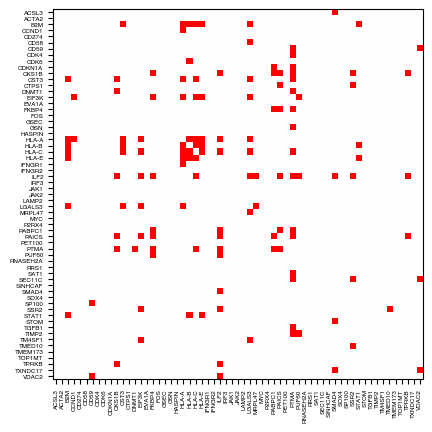

In [34]:
fig, axs = plt.subplots(1)

axs.imshow(implicit_block.nnet_x.get_w_adj().detach().cpu().numpy() > 0.5, cmap="bwr", vmin=-1, vmax=1)

axs.set_xticks(range(61))
_ = axs.set_yticks(range(61))
_ = axs.set_xticklabels(genes["Genes"], rotation=90, fontsize=4.5)
_ = axs.set_yticklabels(genes["Genes"], fontsize=4.5)

fig.savefig("../results/pcs-adj-mat.pdf", bbox_inches="tight")

